## Simple RFM model for Instacart market basket competition on Kaggle.com

### This model works on the hypothesis that more frequently and recently an item is purchased, higher is the probability of the customer re-purchasing it in the future. Also, higher the probability of repurchase, higher will it be in sequence in the cart.

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
import pickle
%matplotlib inline

Database schema
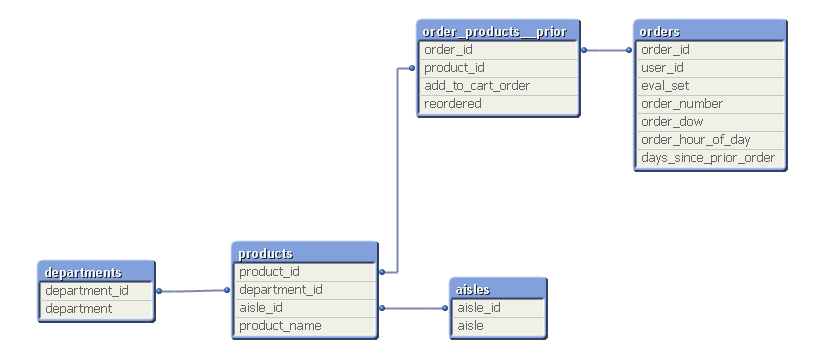

#### We won't be using ailes, departments and products dataset

In [2]:
#aisles = pd.read_csv("aisles.csv")
#departments = pd.read_csv("departments.csv")
orders = pd.read_csv("orders.csv")
order_prior = pd.read_csv("order_products__prior.csv")
order_train = pd.read_csv("order_products__train.csv")
#products = pd.read_csv("products.csv")

In [3]:
#print(aisles.head())
#print(departments.head())
print(orders.head())
print(order_prior.head())
print(order_train.head())
#print(products.head())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
   order_id  product_id  add_to_cart_order  r

#### Orders table has all oders for all users. Column eval_set has values prior (all previous orders for users), train (single order per user for training) or test (single order for prediction without product details). We have to train the model by selecting users with prior and training orders and then predict for users that have prior and testing orders. Let us create separate tables for training and prediction purpose. 

In [3]:
users_train = orders.user_id[orders.eval_set=='train']
data_train = orders[orders['user_id'].isin(users_train)]
data_train.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
users_predict = orders.user_id[orders.eval_set=='test']
data_predict = orders[orders['user_id'].isin(users_predict)]
data_predict.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0


#### To better train the model, select users with higher number of prioir orders created. We are taking median as threshold

In [5]:
data_train.groupby('user_id').order_number.max().median() 

10.0

#### Let us take users that have 10 or more prior orders in the tranining set 

In [6]:
users_10 = data_train.user_id[data_train.order_number > 9]
data_train = data_train[data_train['user_id'].isin(users_10)]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1814094 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 110.7+ MB


#### We will take a single user in the training data set and split it's orders into training and testing using eval_set to check. We are using user id 2 below. 

In [7]:
orders_train = data_train.loc[(data_train.user_id==2) & (data_train.eval_set=='prior'),:]
orders_train = pd.merge(orders_train,order_prior,'inner',on='order_id')
orders_test = data_train.loc[(data_train.user_id==2) & (data_train.eval_set=='train'),:]
orders_test = pd.merge(orders_test,order_train,'inner',on='order_id')
print(orders_train.head())
print(orders_test.head())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2168274        2    prior             1          2                 11   
1   2168274        2    prior             1          2                 11   
2   2168274        2    prior             1          2                 11   
3   2168274        2    prior             1          2                 11   
4   2168274        2    prior             1          2                 11   

   days_since_prior_order  product_id  add_to_cart_order  reordered  
0                     NaN       32792                  1          0  
1                     NaN       47766                  2          0  
2                     NaN       20574                  3          0  
3                     NaN       12000                  4          0  
4                     NaN       48110                  5          0  
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   1492625        2    train           

#### For the single user above, create a table with order number, days since last order and cumulative number of days from from first order

In [8]:
order_days = orders_train[['order_number','days_since_prior_order']]
order_days = order_days.drop_duplicates()
order_days.update(order_days[['days_since_prior_order']].fillna(0))
order_days['cum_days'] = order_days['days_since_prior_order'].cumsum()
order_days

,order_number,days_since_prior_order,cum_days
0,1,0.0,0.0
13,2,10.0,10.0
19,3,3.0,13.0
24,4,8.0,21.0
37,5,8.0,29.0
50,6,13.0,42.0
71,7,14.0,56.0
85,8,27.0,83.0
101,9,8.0,91.0
127,10,6.0,97.0


#### Add the new column for cumulative days to the training dataset

In [10]:
order_map = order_days.groupby('order_number').cum_days.mean().to_dict()
orders_train['cum_days'] = orders_train.order_number.map(order_map)
orders_train.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,cum_days
0,2168274,2,prior,1,2,11,NaN,32792,1,0,0.0
1,2168274,2,prior,1,2,11,NaN,47766,2,0,0.0
2,2168274,2,prior,1,2,11,NaN,20574,3,0,0.0
3,2168274,2,prior,1,2,11,NaN,12000,4,0,0.0
4,2168274,2,prior,1,2,11,NaN,48110,5,0,0.0


#### Calculate recency for each product by first finding out the last time it was ordered and then subracting it from the latest order days. So if a product belonged in the latest order, it's recency will be zero. Convert recency days into recency weeks

In [18]:
recency_map = orders_train.groupby('product_id').cum_days.max().to_dict()
orders_train['recency'] = (orders_train.cum_days.max() - orders_train.product_id.map(recency_map)) / 7
orders_train.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,cum_days,recency
0,2168274,2,prior,1,2,11,NaN,32792,1,0,0.0,6.142857
1,2168274,2,prior,1,2,11,NaN,47766,2,0,0.0,24.142857
2,2168274,2,prior,1,2,11,NaN,20574,3,0,0.0,26.428571
3,2168274,2,prior,1,2,11,NaN,12000,4,0,0.0,14.428571
4,2168274,2,prior,1,2,11,NaN,48110,5,0,0.0,16.428571


#### Calculate frequencies of all products and then normalize by dividing frquency by total number of orders for the user

In [20]:
frequency_map = orders_train['product_id'].value_counts().to_dict()
orders_train['frequency'] = orders_train.product_id.map(frequency_map) / orders_train.order_number.max()
orders_train.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,cum_days,recency,frequency
0,2168274,2,prior,1,2,11,NaN,32792,1,0,0.0,6.142857,0.642857
1,2168274,2,prior,1,2,11,NaN,47766,2,0,0.0,24.142857,0.285714
2,2168274,2,prior,1,2,11,NaN,20574,3,0,0.0,26.428571,0.142857
3,2168274,2,prior,1,2,11,NaN,12000,4,0,0.0,14.428571,0.357143
4,2168274,2,prior,1,2,11,NaN,48110,5,0,0.0,16.428571,0.142857


#### Find average cart order for each product and normalize by dividing by average number of products in the cart

In [21]:
cart_order_map = orders_train.groupby('product_id').add_to_cart_order.mean().to_dict()
orders_train['cart_order'] = orders_train.product_id.map(cart_order_map) / \
                             orders_train.groupby('order_number').order_number.value_counts().mean()
orders_train.head()    

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,cum_days,recency,frequency,cart_order
0,2168274,2,prior,1,2,11,NaN,32792,1,0,0.0,6.142857,0.642857,0.087749
1,2168274,2,prior,1,2,11,NaN,47766,2,0,0.0,24.142857,0.285714,0.358974
2,2168274,2,prior,1,2,11,NaN,20574,3,0,0.0,26.428571,0.142857,0.215385
3,2168274,2,prior,1,2,11,NaN,12000,4,0,0.0,14.428571,0.357143,0.186667
4,2168274,2,prior,1,2,11,NaN,48110,5,0,0.0,16.428571,0.142857,0.358974


#### Create intermediate table that will be used to create final rfm table 

In [22]:
orders_train = orders_train[['product_id','recency','frequency','cart_order']].copy()
orders_train = orders_train.drop_duplicates()
orders_train.head()

,product_id,recency,frequency,cart_order
0,32792,6.142857,0.642857,0.087749
1,47766,24.142857,0.285714,0.358974
2,20574,26.428571,0.142857,0.215385
3,12000,14.428571,0.357143,0.186667
4,48110,16.428571,0.142857,0.358974


#### Create final rfm table by merging it with testing table which will give us buy or no buy for each product.

In [23]:
orders_test['buy'] = 1
orders_test = orders_test[['product_id','buy']]
df = pd.merge(orders_train,orders_test,'left',on='product_id')
df.update(df[['buy']].fillna(0))
df = df.drop(['product_id'], axis = 1)
df.head()

,recency,frequency,cart_order,buy
0,6.142857,0.642857,0.087749,1.0
1,24.142857,0.285714,0.358974,0.0
2,26.428571,0.142857,0.215385,0.0
3,14.428571,0.357143,0.186667,0.0
4,16.428571,0.142857,0.358974,0.0


#### Now that we have seen how to create the table for analysis let us create a function to create the rfm table as above for user ids passed as list

In [24]:
def prepare_rfm(user_ids):
    frames = []
    for user_id in user_ids:
        orders_train = data_train.loc[(data_train.user_id==user_id) & (data_train.eval_set=='prior'),:]
        orders_train = pd.merge(orders_train,order_prior,'inner',on='order_id')
        orders_test = data_train.loc[(data_train.user_id==user_id) & (data_train.eval_set=='train'),:]
        orders_test = pd.merge(orders_test,order_train,'inner',on='order_id')
        frequency_map = orders_train['product_id'].value_counts().to_dict()
        order_days = orders_train[['order_number','days_since_prior_order']]
        order_days = order_days.drop_duplicates()
        order_days.update(order_days[['days_since_prior_order']].fillna(0))
        order_days['cum_days'] = order_days['days_since_prior_order'].cumsum()
        order_map = order_days.groupby('order_number').cum_days.mean().to_dict()
        orders_train['cum_days'] = orders_train.order_number.map(order_map)
        recency_map = orders_train.groupby('product_id').cum_days.max().to_dict()
        orders_train['recency'] = (orders_train.cum_days.max() - orders_train.product_id.map(recency_map)) / 7
        orders_train['frequency'] = orders_train.product_id.map(frequency_map) / orders_train.order_number.max()
        cart_order_map = orders_train.groupby('product_id').add_to_cart_order.mean().to_dict()
        orders_train['cart_order'] = orders_train.product_id.map(cart_order_map) / \
                                     orders_train.groupby('order_number').order_number.value_counts().mean()
        orders_train = orders_train[['product_id','recency','frequency','cart_order']].copy()
        orders_train = orders_train.drop_duplicates()
        orders_test['buy'] = 1
        orders_test = orders_test[['product_id','buy']]
        orders_comb = pd.merge(orders_train,orders_test,'left',on='product_id')
        orders_comb.update(orders_comb[['buy']].fillna(0))
        orders_comb = orders_comb.drop(['product_id'], axis = 1)
        frames.append(orders_comb)
    df = pd.concat(frames)    
    return df

#### We will just select some random 200 users and create an rfm style table. We can select more and actually I had trained the model earlier using 1000 users but it takes more time.

In [26]:
users_train = data_train['user_id'].unique()
user_ids = list(np.random.choice(users_train, 200))
df = prepare_rfm(user_ids)
df.buy.value_counts()

0.0    15802
1.0     1389
Name: buy, dtype: int64

#### Following code can be used to save the data frame as created above and then retrieve it at a later point

In [208]:
#with open('df.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
#    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

#with open('df.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
#    df = pickle.load(f)

#### Build the final model to make the predictions on the test set. We will use logistic regression model as this will give us the probabilities for buying a product. Since the dataset is biased on class, we will use class weight parameter to force it to predict the rare class. Using class weight of 0.12 for class 0 give accuracy of 84% and ROC area 0.75 which is a fair model.

In [40]:
features = ['recency','frequency','cart_order']
X = df[features].copy()
y = df['buy'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
logreg = LogisticRegression(class_weight={0:0.12})
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)
print(accuracy_score(y_true = y_test, y_pred = predictions))
print(roc_auc_score(y_test,predictions))

0.836668217776
0.752737302015


#### Using the logic in prepare rfm function above and with some enhancements, I created a function which will prediction users data and return a list of predicted products. The predict_proba function will return the probability of buying each product for each customer in their prior orders. 

#### I have used a threshold of 0.5 for buy and ordered the products by descending probability value to get the cart order. One can reduce the threshold to a lower value say up to 0.25 because it is better to recommend more products than not to. We will just use first 200 users in the prediction table to make the predictions.

In [43]:
orders_test = data_predict.loc[data_predict.eval_set=='test',:]
orders_test = orders_test.iloc[:200,]
features = ['recency','frequency','cart_order']
submission = []
for index, row in orders_test.iterrows():
    orders_predict = data_predict.loc[(data_predict.user_id==row.user_id) & (data_predict.eval_set=='prior'),:]
    orders_predict = pd.merge(orders_predict,order_prior,'inner',on='order_id')
    frequency_map = orders_predict['product_id'].value_counts().to_dict()
    order_days = orders_predict[['order_number','days_since_prior_order']]
    order_days = order_days.drop_duplicates()
    order_days.update(order_days[['days_since_prior_order']].fillna(0))
    order_days['cum_days'] = order_days['days_since_prior_order'].cumsum()
    order_map = order_days.groupby('order_number').cum_days.mean().to_dict()
    orders_predict['cum_days'] = orders_predict.order_number.map(order_map)
    recency_map = orders_predict.groupby('product_id').cum_days.max().to_dict()
    orders_predict['recency'] = (orders_predict.cum_days.max() - orders_predict.product_id.map(recency_map)) / 7
    orders_predict['frequency'] = orders_predict.product_id.map(frequency_map) / orders_predict.order_number.max()
    cart_order_map = orders_predict.groupby('product_id').add_to_cart_order.mean().to_dict()
    orders_predict['cart_order'] = orders_predict.product_id.map(cart_order_map) / \
                               orders_predict.groupby('order_number').order_number.value_counts().mean()
    orders_predict = orders_predict[['product_id','recency','frequency','cart_order']].copy()
    orders_predict = orders_predict.drop_duplicates()
    df_predict = orders_predict.copy()
    X = df_predict[features].copy()
    y_proba = logreg.predict_proba(X)
    df_pred = pd.DataFrame({"product_id":df_predict['product_id'],"probability":y_proba[:,1]})
    df_pred = df_pred[df_pred.probability >= 0.5]
    df_pred = df_pred.sort_values(["probability"], ascending = False)
    ord_text = str(row['order_id'])
    prods_text = " ".join(str(x) for x in df_pred['product_id'].values)
    submit_text = ord_text + ", " + prods_text
    submission.append([submit_text])   

#### Let us check the first 10 predictions

In [44]:
submission[0:10]

[['2774568, 39190 47766 21903 17668 18599 43961 9387 24810 32402 23650 16797 22035 1819'],
 ['329954, 35469 22199 26576 25146 25623 21573 1200 17769 43704 37646 11865 19057 42329 7160'],
 ['1528013, 38293 21903 49401 25659 8424 20323 40992 27521 45007 11068 48679 10644'],
 ['1376945, 8309 27959 14947 35948 28465 34658 33572 8670 44632 20383 10644 42585 35640 24799 17706 48697 49374 30563 5989 41909 17794 13176 4799 33021 21040'],
 ['1356845, 13176 14992 10863 7076 28134 21616 8239 5746 20350 44422 11520 31506 22959 7120 37687 19006 39667 17794 30489 49683 24390 47509 34243 48364 16185 248 42736 19895 18761 45056 37646 38693 47144 44661 22935 35345 12797 10978 33443 28342 20144'],
 ['2161313, 14715 12427 11266 10441 37710 27839 196 48142 1747'],
 ['1416320, 21903 5134 41950 17948 24852 21137 48745 651 4086 43014 24561 15872 21405 28985 14197 21616 28289 48283 32691 44359 17794 7948 27104'],
 ['1735923, 17008 35123 2192 12108 15131 24629 18174 31487 34690 15599 196 5183 30123 45037 27138